# Density based clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

First, a normalization is needed.

In [2]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
scaler = MinMaxScaler()
X = scaler.fit_transform(quant.values)

It is necessary to embed the dataset in a lower-dimensional space. I choose to use ISOMAP

In [3]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## DBSCAN

In [16]:
from sklearn.cluster import DBSCAN

N = 20

dbscan_df = pd.DataFrame(columns=["eps", "silhouette score", "n_clusters", "maxAMI", "meanAMI", "noise population"])

epsilons = np.linspace(0.22,0.36, N)

for i,eps in enumerate(epsilons):
    record = dict(eps=eps, meanAMI=0, maxAMI=0)
    record["silhouette score"] = 0
    
    clustering = DBSCAN(eps=eps, min_samples=20).fit(X)
    if not np.all(clustering.labels_==-1) :
        filter_outlier = (clustering.labels_ != -1)
        record["n_clusters"] = len(np.unique(clustering.labels_[filter_outlier]))
        if len(np.unique(clustering.labels_[filter_outlier])) > 1:
            record["silhouette score"] = silhouette_score(X[filter_outlier], clustering.labels_[filter_outlier])
    else:
        record["silhouette score"] = 0
        record["n_clusters"] = 0
    record["noise population"] = (clustering.labels_ == -1).sum()/len(clustering.labels_)

    for cat in categ.columns:
        record["maxAMI"] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_), record["maxAMI"])
        record["meanAMI"] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)
    
    record=pd.DataFrame(record, index=[0])
    dbscan_df = pd.concat([dbscan_df, record], ignore_index=True)

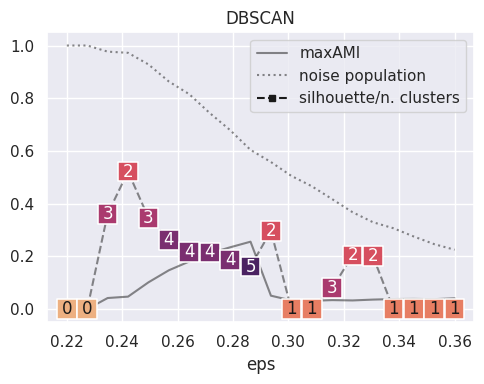

In [17]:
fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=dbscan_df, x="eps", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=dbscan_df, x="eps", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=dbscan_df, x="eps", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dbscan_df, x="eps", y="silhouette score", hue="n_clusters", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dbscan_df.iterrows():
    if record["n_clusters"] > 1:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_clusters"])), (record["eps"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. clusters', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("DBSCAN")
plt.ylabel("")
plt.savefig("DBSCAN_sil.pdf")

/tmp/ipykernel_37248/3875679314.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "eps":eps }), ignore_index=True)
/tmp/ipykernel_37248/3875679314.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "eps":eps }), ignore_index=True)
/tmp/ipykernel_37248/3875679314.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "eps":eps }), ignore_index=True)
/tmp/ipyke

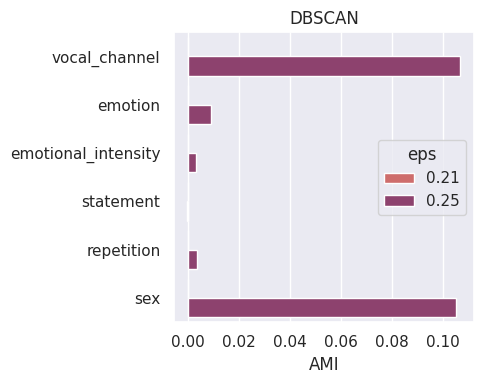

In [18]:
eps, min_samples = 0.21, 20


fig, ax = plt.subplots(figsize=(5,4))

mi_df= pd.DataFrame(columns = ["category", "AMI", "n_clusters"])
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "eps":eps }), ignore_index=True)

eps, min_samples = 0.25, 20


clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "eps":eps }), ignore_index=True)

sns.barplot(data=mi_df, x ="AMI", y="category", hue="eps", palette="flare")

plt.ylabel("")
# plt.legend([],[], frameon=False)
plt.title("DBSCAN")
plt.savefig("DBSCAN_MI.pdf")


## OPTICS

In [19]:
from sklearn.cluster import OPTICS

xis = np.linspace(0.01, 0.25, 20)
N = len(xis)
sil = np.zeros(N)
label_number = np.zeros(N)
max_mutual_info = np.zeros(N)
mean_mutual_info = np.zeros(N)
cluster_people_over_noise = np.zeros(N)


for i,xi in enumerate(xis):
    clustering = OPTICS(xi=xi).fit(X)
    if not np.all(clustering.labels_==-1) :
        filter_outlier = (clustering.labels_ != -1)
        label_number[i] = len(np.unique(clustering.labels_[filter_outlier]))
        if len(np.unique(clustering.labels_[filter_outlier])) > 1:
            sil[i] = silhouette_score(X[filter_outlier], clustering.labels_[filter_outlier])
    else:
        sil[i] = 0
        label_number[i] = 0
    cluster_people_over_noise[i] = (clustering.labels_ == -1).sum()/len(clustering.labels_)
    for cat in categ.columns:
        max_mutual_info[i] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_), max_mutual_info[i])
        mean_mutual_info[i] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)

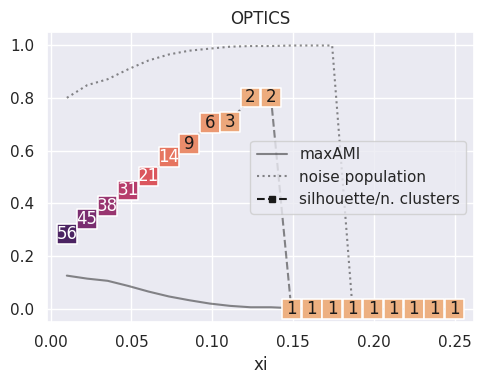

In [20]:
dummy_df = pd.DataFrame()
dummy_df["xi"] = xis
dummy_df["silhouette score"] = sil
dummy_df["n_labels"] = label_number
dummy_df["maxAMI"] = max_mutual_info
dummy_df["meanAMI"] = mean_mutual_info
dummy_df["noise population"] = cluster_people_over_noise


fig, ax = plt.subplots(figsize=(5,4))

sns.lineplot(data=dummy_df, x="xi", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=dummy_df, x="xi", y="noise population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=dummy_df, x="xi", y="silhouette score", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=dummy_df, x="xi", y="silhouette score", hue="n_labels", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in dummy_df.iterrows():
    if record["n_labels"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_labels"])), (record["xi"], record["silhouette score"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. clusters', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("OPTICS")
plt.ylabel("")
plt.savefig("OPTICS_sil.pdf")

/tmp/ipykernel_37248/2579833299.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "xi":xi }), ignore_index=True)
/tmp/ipykernel_37248/2579833299.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "xi":xi }), ignore_index=True)
/tmp/ipykernel_37248/2579833299.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "xi":xi }), ignore_index=True)
/tmp/ipykernel_3724

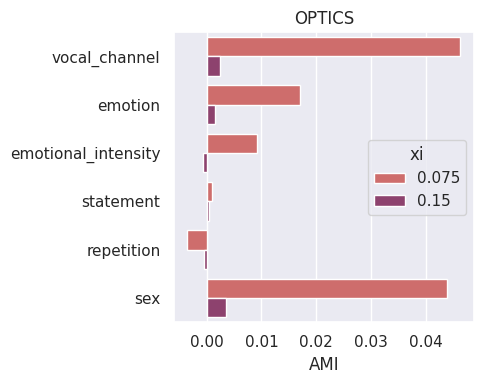

In [21]:
xi=0.075

fig, ax = plt.subplots(figsize=(5,4))

mi_df= pd.DataFrame(columns = ["category", "AMI", "xi"])
clustering = OPTICS(xi=xi).fit(X)

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "xi":xi }), ignore_index=True)

xi = 0.15
clustering = OPTICS(xi=xi).fit(X)
for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "xi":xi }), ignore_index=True)

sns.barplot(data=mi_df, x ="AMI", y="category", hue="xi", palette="flare")

plt.ylabel("")
# plt.legend([],[], frameon=False)
plt.title("OPTICS")
plt.savefig("OPTICS_MI.pdf")


## OPTICS varying eps

In [22]:
from sklearn.cluster import OPTICS

max_epss = np.linspace(0.1, 0.35, 20)
xis = np.linspace(0.05,0.2, 5)
optics_df = pd.DataFrame(columns=["max_eps", "xi",  "silhouette", "n_clusters", "maxAMI", "meanAMI", "noise_population"])

for xi in xis:
    for me in max_epss:
        record = dict([])

        record["max_eps"] = me
        record["xi"] = xi
        clustering = OPTICS(max_eps=me, xi=xi).fit(X)
        if not np.all(clustering.labels_==-1) :
            filter_outlier = (clustering.labels_ != -1)
            record["n_clusters"] = len(np.unique(clustering.labels_[filter_outlier]))
            if len(np.unique(clustering.labels_[filter_outlier])) > 1:
                record["silhouette"] = silhouette_score(X[filter_outlier], clustering.labels_[filter_outlier])
            else:
                record["silhouette"] = 0
        else:
            record["silhouette"] = 0
            record["n_clusters"] = 0
        
        record["noise_population"] = (clustering.labels_ == -1).sum()/len(clustering.labels_)

        record["maxAMI"] = 0
        record["meanAMI"] = 0
        for cat in categ.columns:
            record["maxAMI"] = max(adjusted_mutual_info_score(categ[cat], clustering.labels_),record["maxAMI"])
            record["meanAMI"] += adjusted_mutual_info_score(categ[cat], clustering.labels_)/len(categ.columns)
        optics_df = pd.concat([optics_df, pd.DataFrame(record, index=[0])], ignore_index=True)

optics_df.to_csv('optics_dataframe.csv', index=False)

    

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/cluster/_optics.py:570: UserWarning: All reachability values are inf. Set a larger max_eps or all data will be considered outliers.
  warnings.warn(
/home/djanloo/.local

In [23]:
optics_df.xi = optics_df.xi.apply(lambda x: round(x, 2))

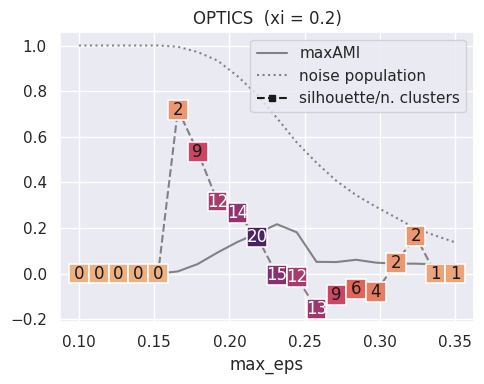

In [24]:
fig, ax = plt.subplots(figsize=(5,4))
filter_xi = (optics_df.xi==0.2)
sns.lineplot(data=optics_df[filter_xi], x="max_eps", y="maxAMI", color="k", alpha=0.5)
sns.lineplot(data=optics_df[filter_xi], x="max_eps", y="noise_population", color="k", alpha=0.5, ls=":")

sns.lineplot(data=optics_df[filter_xi], x="max_eps", y="silhouette", alpha=0.5, color= "k" , ls="--", zorder=1)
sns.scatterplot(data=optics_df[filter_xi], x="max_eps", y="silhouette", hue="n_clusters", s=200, palette="flare", legend=False, marker="s", zorder=2)

for i, record in optics_df[filter_xi].iterrows():
    if record["n_clusters"] > 10:
        color = "white"
    else:
        color="k"
    plt.annotate(str(int(record["n_clusters"])), (record["max_eps"], record["silhouette"]), ha="center", va="center", color=color, zorder=3)



legend_elements = [Line2D([0], [0], color='k', alpha=0.5, label='maxAMI'),
                    Line2D([0], [0], color='k', alpha=0.5, ls=":", label='noise population'),
                   Line2D([0], [0], marker='s', color='k', ls="--" ,label='silhouette/n. clusters', markersize=5)]

ax.legend(handles=legend_elements)
plt.title("OPTICS  (xi = 0.2)")
plt.ylabel("")
plt.savefig("OPTICS_sil.pdf")

/tmp/ipykernel_37248/459855052.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "max_eps":max_eps }), ignore_index=True)
/tmp/ipykernel_37248/459855052.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "max_eps":max_eps }), ignore_index=True)
/tmp/ipykernel_37248/459855052.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "max_eps":max_eps }), ignore_inde

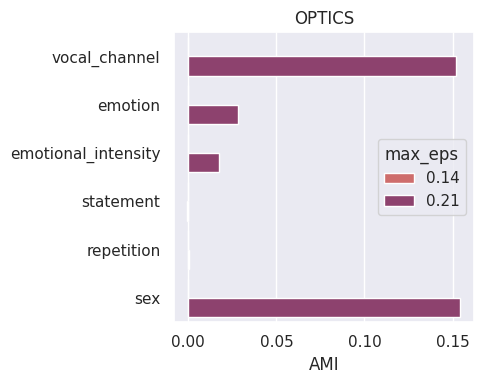

In [25]:
max_eps, xi = 0.21, 0.2

fig, ax = plt.subplots(figsize=(5,4))

mi_df= pd.DataFrame(columns = ["category", "AMI", "max_eps"])
clustering = OPTICS(max_eps=max_eps, xi=xi).fit(X)

for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "max_eps":max_eps }), ignore_index=True)

max_eps = .14
clustering = OPTICS(max_eps=max_eps, xi=xi).fit(X)
for cat in categ.columns:
    mi_df = mi_df.append(pd.DataFrame({"category": [cat], "AMI": [adjusted_mutual_info_score(categ[cat], clustering.labels_)], "max_eps":max_eps }), ignore_index=True)

sns.barplot(data=mi_df, x ="AMI", y="category", hue="max_eps", palette="flare")

plt.ylabel("")
plt.title("OPTICS")
plt.savefig("OPTICS_MI.pdf")